## Описание проекта

Собраны исторические данные о заказах такси. Нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

### Описание данных
datetime - дата
<br>
<br>
целевой признак:<br>
num_orders - кол-во заказов

### План работы:
<a href='#step_1'>Шаг 1. Получение общей информации и подготвка данных.</a><br>
На первом этапе импортируем необходимые библиотеки и читаем файл, знакомимся с общей информацией, выставляем необходимые типы данных, проверяем пропуски.<br>
<a href='#step_2'>Шаг 2. Анализ</a><br>
Анализ временного ряда, выделение сезонности и трендов.<br>
<a href='#step_3'>Шаг 3. Обучение моделей.</a><br>
Обучение моделей и подбор гиперпараметров.<br>
<a href='#step_4'>Шаг 4. Тестирование моделей.</a><br>
Сравнение результатов работы моделей.<br>
<a href='#step_5'>Шаг 5. Общий вывод.</a><br>

# Подготовка

План работы:<br>
<a href='#step_1'>Шаг 1. Получение общей информации и подготвка данных.</a><br>
<a href='#step_2'>Шаг 2. Анализ</a><br>
<a href='#step_3'>Шаг 3. Обучение моделей.</a><br>
<a href='#step_4'>Шаг 4. Тестирование моделей.</a><br>
<a href='#step_5'>Шаг 5. Общий вывод.</a><br>

<a id ='step_1'></a>

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col = 0, parse_dates = [0])
data.sort_index(inplace = True)
display(data.head())
print()
data.info()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


Пропусков нет, типы данных правильные. Диапозон времени март 2018 - август 2018(включительно).

In [3]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Аномальных значений вроде нет, в среднем за 10 минут 14 +-9 вызовов.

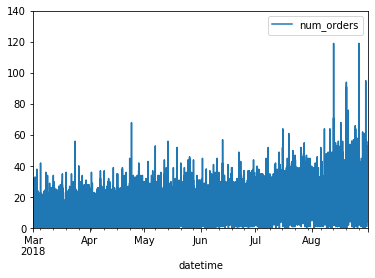

In [4]:
data.plot(ylim = (0,140))

119 вызовов такси было в августе, вероятно, пик сезонности отпусков.

In [5]:
data = data.resample('1H').sum()
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


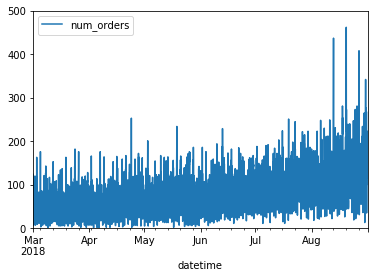

In [6]:
data.plot(ylim = (0,500))

разобьем дату на составляющие.

# Анализ

План работы:<br>
<a href='#step_1'>Шаг 1. Получение общей информации и подготвка данных.</a><br>
<a href='#step_2'>Шаг 2. Анализ</a><br>
<a href='#step_3'>Шаг 3. Обучение моделей.</a><br>
<a href='#step_4'>Шаг 4. Тестирование моделей.</a><br>
<a href='#step_5'>Шаг 5. Общий вывод.</a><br>

<a id ='step_2'></a>

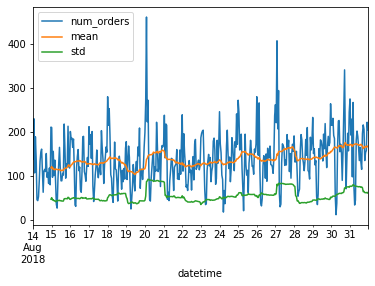

In [7]:
df_row = pd.read_csv('/datasets/taxi.csv', index_col = 0, parse_dates = [0])
df_row.sort_index(inplace = True)
df_row = df_row['2018-08-14':'2018-08-31'].resample('1H').sum()
df_row['mean'] = df_row['num_orders'].rolling(24).mean()
df_row['std'] = df_row['num_orders'].rolling(24).std()
df_row.plot()

Начнем с того, что ряд нестационарный из-за изменчивость среднего и стандратного отклонения.

In [8]:
df = pd.read_csv('/datasets/taxi.csv', index_col = 0, parse_dates = [0])
df.sort_index(inplace = True)
df = df.resample('1H').sum()

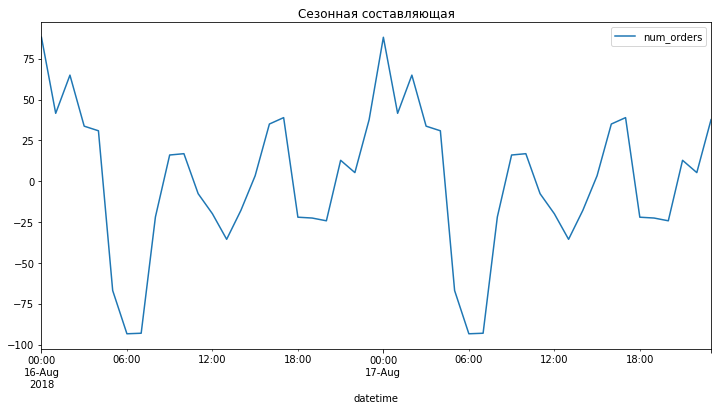

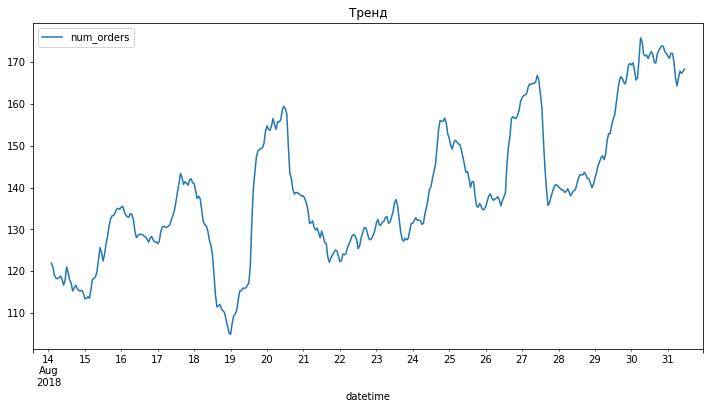

In [9]:
train, test = train_test_split(df, test_size = 0.1, shuffle = False, random_state = 40)
seasonal = seasonal_decompose(test)

seasonal.seasonal['2018-08-16':'2018-08-17'].plot(title = 'Сезонная составляющая', figsize = (12,6))
seasonal.trend.plot(title = 'Тренд', figsize = (12,6))

Сезонная составляющая - 24 часа.<br>
Тренд - увеличение кол-ва вызовов такси летом.

# Обучение

План работы:<br>
<a href='#step_1'>Шаг 1. Получение общей информации и подготвка данных.</a><br>
<a href='#step_2'>Шаг 2. Анализ</a><br>
<a href='#step_3'>Шаг 3. Обучение моделей.</a><br>
<a href='#step_4'>Шаг 4. Тестирование моделей.</a><br>
<a href='#step_5'>Шаг 5. Общий вывод.</a><br>

<a id ='step_3'></a>

In [10]:
def create_shift(dataframe, shift, num_roll):
    dataframe['year'] = dataframe.index.year
    dataframe['month'] = dataframe.index.month
    dataframe['day'] = dataframe.index.day
    dataframe['dayofweek'] = dataframe.index.dayofweek
    dataframe['hour'] = dataframe.index.hour
    for i in range(1, shift + 1):
        dataframe['shift_by_{}'.format(i)] = dataframe['num_orders'].shift(i)
    dataframe['rolling_mean'] = dataframe['num_orders'].shift().rolling(num_roll).mean()
    return dataframe
data = create_shift(data, 24, 12).dropna()

Сдвиг взял равным сезонности, скользящее среднее в два раза меньше.

Создал новые столбцы с помощью функции с указанным сдвигом.

In [11]:
target = data['num_orders']
features = data.reset_index().drop(['num_orders', 'datetime'], axis = 1)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size = 0.1, shuffle = False, random_state = 42)

Разделил на выборки

<b>Кросс-валидация моделей.</b><br>
в проекте прописаны модели с заранее определенными оптимальными гиперараметрами. При желании можно сделать ячейки 'кодовыми' и убрать переходы.

cat_features = data[['year', 'month', 'day', 'dayofweek']]<br>
model = CatBoostRegressor(iterations = 400, verbose= 200, cat_features=cat_features)<br>
parametrs_catboost = {'depth': range(4, 8),<br>
                      'learning_rate': np.arange(0.6, 1, 0.1)}<br>
grid_catboost = GridSearchCV(model, parametrs_catboost,<br>
                             cv = TimeSeriesSplit(n_splits = 3).split(features_train),<br>
                             scoring='neg_mean_squared_error')<br>
grid_catboost.fit(features_train, target_train)<br>
grid_catboost.best_params_

{'depth': 6, 'learning_rate': 0.6} - лучшие параметры

In [12]:
cat_features = data[['year', 'month', 'day', 'dayofweek']]
model = CatBoostRegressor(iterations = 400, verbose= 200, cat_features=cat_features, depth = 6, learning_rate = 0.6)
model.fit(features_train, target_train)

0:	learn: 29.6108867	total: 51.9ms	remaining: 20.7s
200:	learn: 7.1573361	total: 6.84s	remaining: 6.78s
399:	learn: 3.3584653	total: 14.2s	remaining: 0us


model_lgbm = LGBMRegressor(iterations = 400)<br>
parametrs_lgbm = {'max_depth': range(4, 8),<br>
                  'learning_rate': np.arange(0.6, 1, 0.1)}<br>
grid_lgbm = GridSearchCV(model_lgbm, parametrs_lgbm,<br>
                         cv=TimeSeriesSplit(n_splits = 3).split(features_train),<br>
                         scoring='neg_mean_squared_error')<br>
grid_lgbm.fit(features_train, target_train)<br>
grid_lgbm.best_params_

{'learning_rate': 0.6, 'max_depth': 4} - лучшие параметры

In [13]:
model_lgbm = LGBMRegressor(iterations=400,max_depth = 4, learning_rate = 0.6)
model_lgbm.fit(features_train, target_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', iterations=400, learning_rate=0.6,
              max_depth=4, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
              objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

model_xgb = xgb.XGBRegressor(n_estimators=400, objective='reg:squarederror', verbosity = 1)<br>
parametrs_xgb = {'max_depth': range(3, 8),<br>
                 'learning_rate': np.arange(0.6, 1, 0.1)}<br>
grid_xgb = GridSearchCV(model_xgb,<br>
                        parametrs_xgb,<br>
                        cv = TimeSeriesSplit(n_splits = 3).split(features_train),<br>
                        scoring='neg_mean_squared_error')<br>
grid_xgb.fit(features_train, target_train)<br>
grid_xgb.best_params_

{'learning_rate': 0.6, 'max_depth': 5} - лучшие параметры

In [14]:
model_xgb = xgb.XGBRegressor(n_estimators=400,max_depth = 3, learning_rate = 0.6,
                             objective='reg:squarederror', verbosity = 1)
model_xgb.fit(features_train, target_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.6, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=400,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

model_forest = RandomForestRegressor(verbose = 1)<br>
parametrs_forest = {'max_depth': range(3, 8),<br>
                    'n_estimators': range(100,400,100)}<br>
grid_forest = GridSearchCV(model_forest,<br>
                           parametrs_forest,<br>
                           cv = TimeSeriesSplit(n_splits = 3).split(features_train),<br>
                           scoring='neg_mean_squared_error')<br>
grid_forest.fit(features_train, target_train)<br>
grid_forest.best_params_

{'max_depth': 7, 'n_estimators': 200} - лучшие параметры

In [15]:
model_forest = RandomForestRegressor(n_estimators=100, max_depth = 7, verbose = 1)
model_forest.fit(features_train, target_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.9s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=1, warm_start=False)

In [16]:
model_linear = LinearRegression()
model_linear.fit(features_train, target_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# Тестирование

План работы:<br>
<a href='#step_1'>Шаг 1. Получение общей информации и подготвка данных.</a><br>
<a href='#step_2'>Шаг 2. Анализ</a><br>
<a href='#step_3'>Шаг 3. Обучение моделей.</a><br>
<a href='#step_4'>Шаг 4. Тестирование моделей.</a><br>
<a href='#step_5'>Шаг 5. Общий вывод.</a><br>

<a id ='step_4'></a>

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


,0
catboost,44.307822
lgbm,43.769828
xgb,44.737260
forest,45.464687
linear,45.834474


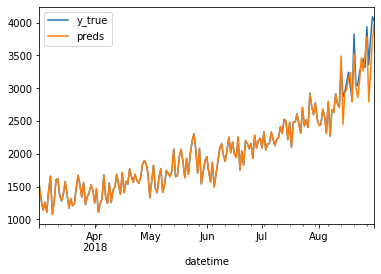

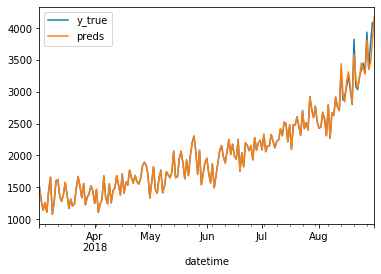

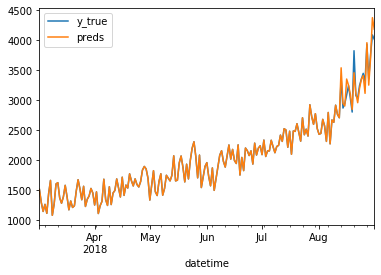

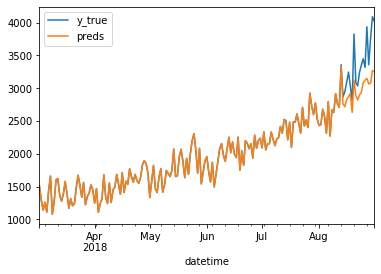

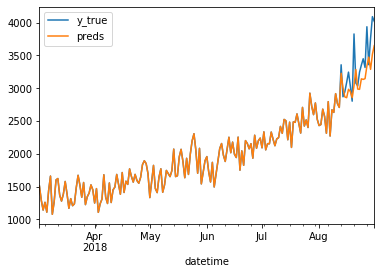

In [17]:
models = [model, model_lgbm, model_xgb, model_forest, model_linear]
predictions = []
columns = ['catboost', 'lgbm', 'xgb', 'forest', 'linear']
for i in models:
    preds = i.predict(features_test)
    #pd.DataFrame({'preds':preds, 'y_true':target_test.values}).plot(figsize = (12,6))
    otris = pd.DataFrame({'y_true' : data['num_orders'], 'preds': data['num_orders']})
    otris.loc[3952:,'preds'] = preds
    otris.resample('1D').sum().plot()
    predictions.append(mean_squared_error(target_test, preds)**0.5)
pd.DataFrame(index = columns, data = predictions)

Лучшей с подобранными параметрами оказалась LightGBM, худшей - линейная регрессия.

# Общий вывод

План работы:<br>
<a href='#step_1'>Шаг 1. Получение общей информации и подготвка данных.</a><br>
<a href='#step_2'>Шаг 2. Анализ</a><br>
<a href='#step_3'>Шаг 3. Обучение моделей.</a><br>
<a href='#step_4'>Шаг 4. Тестирование моделей.</a><br>
<a href='#step_5'>Шаг 5. Общий вывод.</a><br>

<a id ='step_5'></a>

При ознакомлении с данными не было обнаружено пропусков или неправильно определенных типов данных.<br>
Далее построено распределение и определено, что ряд нестационарный.<br>
После выявлены тренд (к лету вызовов больше) и сезонная составляющая(неделя).<br>
В продолжении работы обучены различиные модели, найдены подходящие гиперпараметры.<br>
В конце протестирована работа моделей и показано их сравнение. Лучшей оказалась модель LightGBM.